# Rationale
It is suspicious that models with a high (>98%) accuracy on cross validation with the training set should score barely better than chance (52-54%) on the test set.  From an initial comparison of the two data sets it appears that for some features the values in the tests set are considerably different from the values in the training set.  Prediction is only possible if both the training set and test set are drawn from the same underlying population and have features that have been identically processed.

This notebook investigates the hypothesis that there is some systematic bias or difference between the two data sets that makes accurate prediction impossible.  

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
train_data = pd.read_csv('train_imperson_without4n7_balanced_data.csv')
X_train, Y_train = train_data.loc[:, train_data.columns != '155'], train_data['155']

test_data = pd.read_csv('test_imperson_without4n7_balanced_data.csv')
X_test, Y_test = test_data.loc[:, test_data.columns != '155'], test_data['155']

Get the columns with no variance and check they are the same for both data sets.

In [3]:
train_no_var = X_train.var() == 0.0
test_no_var = X_test.var() == 0.0
all(train_no_var == test_no_var)

False

OK, so the columns in the training set with no variance are different from the columns in the test set with no variance.  Let investigate them further...

In [4]:
X_train[X_train.columns[train_no_var != test_no_var]].describe()

,69,81,83,84,86,88,97,113,117,133,138,148
count,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.00000,97044.000000,97044.000000,97044.00000,97044.000000,97044.0
mean,0.0,0.0,0.000021,0.000062,0.000082,0.000014,0.00001,0.000013,0.000006,0.00001,0.500004,0.0
std,0.0,0.0,0.004540,0.007863,0.009079,0.002451,0.00321,0.002383,0.000911,0.00321,0.001220,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.500000,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.500000,0.0
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.500000,0.0
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.500000,0.0
max,0.0,0.0,1.000000,1.000000,1.000000,0.468750,1.00000,0.428570,0.156110,1.00000,0.880000,0.0


In [5]:
X_test[X_test.columns[train_no_var != test_no_var]].describe()

,69,81,83,84,86,88,97,113,117,133,138,148
count,40158.000000,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000
mean,0.463320,0.042274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000025
std,0.498659,0.068034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004990
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,1.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,1.000000,0.272730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


Lets see what the actual values are in these columns:

In [6]:
{
    col: list(X_train[col].value_counts().items()) 
    for col in X_train[X_train.columns[train_no_var != test_no_var]].columns
}

{'69': [(0, 97044)],
 '81': [(0, 97044)],
 '83': [(0, 97042), (1, 2)],
 '84': [(0, 97038), (1, 6)],
 '86': [(0, 97036), (1, 8)],
 '88': [(0.0, 97038), (0.03125, 3), (0.46875, 2), (0.375, 1)],
 '97': [(0, 97043), (1, 1)],
 '113': [(0.0, 97041), (0.42857, 3)],
 '117': [(0.0, 97036),
  (0.0034351, 3),
  (0.15611, 2),
  (0.11412, 1),
  (0.097328, 1),
  (0.096183, 1)],
 '133': [(0, 97043), (1, 1)],
 '138': [(0.5, 97043), (0.88, 1)],
 '148': [(0, 97044)]}

In [7]:
{col: list(X_test[col].value_counts().items()) 
    for col in X_test[X_test.columns[train_no_var != test_no_var]].columns
}

{'69': [(0, 21552), (1, 18606)],
 '81': [(0.0, 27711),
  (0.090909, 6243),
  (0.18182, 6181),
  (0.27273000000000003, 23)],
 '83': [(0, 40158)],
 '84': [(0, 40158)],
 '86': [(0, 40158)],
 '88': [(0, 40158)],
 '97': [(0, 40158)],
 '113': [(0, 40158)],
 '117': [(0, 40158)],
 '133': [(0, 40158)],
 '138': [(0, 40158)],
 '148': [(0, 40157), (1, 1)]}

From the above we can see that there are 9 features that have variance in the training set but no variance in test set, and three features the other way round.  For most of the cases the columns with variance only have a single value or handful of values that differ, so are unlikely to have much effect on any model trained on the data.

We shall exclude all these features from further investigation, along with the features that have no variance for either data set.

In [8]:
X_train_with_var = X_train[X_train.columns[~(train_no_var | test_no_var)]]
X_test_with_var = X_test[X_test.columns[~(train_no_var | test_no_var)]]

X_train_with_var.shape, X_test_with_var.shape

((97044, 69), (40158, 69))

By eliminating features that have no variance in either the training or test set (or both) we are left with 69 features.  

We now want to test for each feature in the remaining data sets whether the feature in the test set comes from the same distribution as the same feature in the training set.  We shall use the ks2_samp function to determine this.

In [9]:
ks_pvalues = {col: stats.ks_2samp(X_train[col], X_test[col]).pvalue 
    for col in X_train_with_var.columns
}
ks_pvalues

{'5': 0.0,
 '6': 0.0,
 '8': 0.0,
 '9': 0.0,
 '14': 1.0,
 '15': 1.0,
 '16': 1.0,
 '18': 1.0,
 '20': 1.0,
 '26': 1.0,
 '29': 1.0,
 '38': 0.0,
 '43': 1.0,
 '47': 4.854342014699145e-109,
 '48': 1.0,
 '50': 2.1319088282967322e-89,
 '51': 3.7396694731191775e-89,
 '52': 1.0,
 '61': 0.0,
 '62': 1.0,
 '64': 1.0315072609922148e-131,
 '66': 7.746639575795464e-91,
 '67': 3.503944077968135e-64,
 '68': 4.51926145509109e-49,
 '70': 7.306613166889381e-41,
 '71': 0.0,
 '72': 0.995487532890464,
 '73': 2.810115497553139e-53,
 '75': 0.0,
 '76': 0.0,
 '77': 0.0,
 '78': 0.0,
 '79': 0.0,
 '80': 0.0,
 '82': 0.0,
 '89': 1.0,
 '90': 0.3461723270023699,
 '93': 2.3612312065919717e-20,
 '94': 0.9999999999999997,
 '98': 0.4145970321873381,
 '104': 0.8784705620648641,
 '105': 1.0,
 '106': 1.0,
 '107': 3.2841854096356005e-09,
 '108': 2.5745299377723217e-210,
 '109': 0.8014300689769817,
 '110': 2.0290749144082378e-94,
 '111': 1.0,
 '112': 0.478879497860954,
 '118': 0.43558042845336914,
 '119': 4.06200452902175e-200,
 

In [10]:
len([x for x in ks_pvalues.values() if x < 0.05])

40

High p-values mean that column probably comes from the same distribution, low pvalues mean they probably come from a different distribution, at least as far as the Kolmogorov-Smirnov test can tell.  From the above you can see that 40 of the 69 features have a p-value of less than 0.05 and many of them have a p-value of zero.

Lets focus on the features that our team identified as being the most important for training the model.  We found that just six features could be used to create a model that scored in excess of 98% in cross validation on the training data, but barely more than 52% on the test data.  It turns out that all these features score close to zero p-value on the KS test:

In [11]:
best_features = ['8', '38', '67', '76', '78', '119']
[(f, ks_pvalues[f]) for f in best_features]

[('8', 0.0),
 ('38', 0.0),
 ('67', 3.503944077968135e-64),
 ('76', 0.0),
 ('78', 0.0),
 ('119', 4.06200452902175e-200)]

In [12]:
X_train[best_features].describe()

,8,38,67,76,78,119
count,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000
mean,0.193837,0.713756,0.376979,0.003294,0.002077,0.000336
std,0.354444,0.109809,0.395372,0.021005,0.017849,0.011518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037908,0.654075,0.000000,0.000563,0.001731,0.000000
50%,0.037908,0.757210,0.307690,0.000563,0.001731,0.000000
75%,0.054902,0.767550,0.615380,0.002253,0.001731,0.000000
max,1.000000,0.933540,1.000000,0.990990,0.995670,0.994750


In [13]:
X_test[best_features].describe()

,8,38,67,76,78,119
count,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000
mean,0.200639,0.944178,0.341793,0.021087,0.003357,0.001407
std,0.371463,0.040206,0.385898,0.037241,0.007230,0.005267
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016993,0.905910,0.000000,0.005291,0.002146,0.000000
50%,0.016993,0.967410,0.000000,0.005291,0.002146,0.000000
75%,0.060131,0.975510,0.615380,0.026455,0.002146,0.000000
max,1.000000,0.978310,1.000000,0.835980,0.963520,0.161700


Lets take a closer look at one of the features in particular that show a large discrepancy.  
We can compare the training and testing version of feature 38 by plotting them on a histogram.  I am using a log scale, otherwise the smaller bins will not show up on the plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd560b290b8>,
      dtype=object)

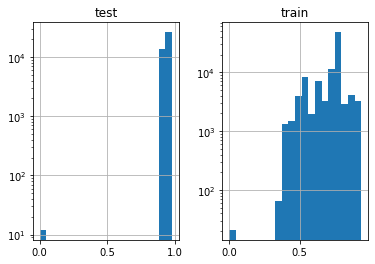

In [14]:
pd.DataFrame({'train':X_train['38'], 'test':X_test['38']}).hist(log=True, bins=20)

From the above histograms you can clearly see that the training data has a wide range of values and has most values between 0.5 and 0.8.  The training data however has all its values up near 1.0 with a handful at zero.  This is extremely unlikely if both data sets are identically and independantly drawn from the same population.

You can see the shape of the distributions more clearly on a KDE plot:

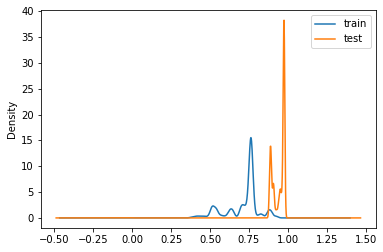

In [15]:
pd.DataFrame({'train':X_train['38'], 'test':X_test['38']}).plot.kde()

From this plot it appears that the overall shape is similar but shifted up on the test set.  One possible reason for this could be that the data sets were wrongly scaled.  You could get this effect if it the training set and test set had been scaled independently instead of the scaler being fit to the training data and applied to the test data - an outlier in the training set could push all the other values down after scaling. Unfortunately all the data had been scaled to be between 0 and 1 before we got it and we do not have access to the original data to test this hypothesis.

Another indicator that this could be the case is that the maximum value of all features in the test set is never more than 1.0.  If a scaler had been fit to the training set and then applied to the test set it would be likely that a few features in the test set would have a maximum value greater than 1.0 (unless the features were all categorical).

There are also several features that appear to be categorical with two or three categories, but the categories have been scaled to completely different values:

In [33]:
for col in ['128', '129', '122']:
    print(f"Training data feature {col} (value, count)")
    print(list(X_train[col].value_counts().items()))
    print(f"Test data feature {col} (value, count)")
    print(list(X_test[col].value_counts().items()))
    print()
        

Training data feature 128 (value, count)
[(0.0, 94954), (3.09e-05, 1943), (1.55e-05, 147)]
Test data feature 128 (value, count)
[(0.0, 38897), (1.0, 1120), (0.5, 141)]

Training data feature 129 (value, count)
[(0.0, 94954), (1.58e-05, 2090)]
Test data feature 129 (value, count)
[(0, 38897), (1, 1261)]

Training data feature 122 (value, count)
[(0.0, 93530), (0.0039683, 2571), (0.007936499999999999, 943)]
Test data feature 122 (value, count)
[(0.0, 38223), (0.33333, 1423), (0.66667, 512)]



From the above we see that for example feature 128 has three distinct values for both test and training data, but for the training data they take the values 0.0, 0.000015 and 0.00003, while for the test data they take the values 0.0, 0.5 and 1.0.  It is the same for features 129 and 122 (and probably others) - there are orders of magnitude difference in the values taken for the categories.


We can get an idea of which features suffer from this problem by looking for features in the test set where the maximum value is more than twice that of the maximum value in the training set, or vice versa:

In [52]:
train_max = X_train_with_var.max()
test_max = X_test_with_var.max()
bad_max = (train_max < test_max/2) | (test_max < train_max/2)

pd.DataFrame({'train_max': train_max[bad_max], 'test_max': test_max[bad_max]})

,train_max,test_max
80,0.539070,0.040964
104,1.000000,0.100000
108,0.001530,1.000000
110,0.000125,0.750000
119,0.994750,0.161700
121,0.004566,0.500000
122,0.007936,0.666670
125,0.333330,1.000000
126,0.000015,1.000000
127,0.015686,0.500000


# Conclusion

It is clear that there are serious discrepancies between the data in the test set and the data in the training set.  This will cause serious problems for anyone trying to build a model using the training data and then validate it against the test set.  